In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pathpy
import pickle as pkl
import pycountry
import re
import teneto

from preprocessing import load_data, preprocess_data

In [151]:
# Load and save data
data = load_data('DS_GlobalTradeAtlas')
with open('data.pkl', 'wb') as f:
    pkl.dump(data, f)

In [3]:
# Preprocess data
with open('data.pkl', 'rb') as f:
    data = pkl.load(f)
data = preprocess_data(data)

In [4]:
data.head()

,YEAR,MONTH,COMMODITY,COUNTRY_IN,REGION_IN,SUBREGION_IN,COUNTRY_CODE_IN,LATITUDE_IN,LONGITUDE_IN,COUNTRY_OUT,REGION_OUT,SUBREGION_OUT,COUNTRY_CODE_OUT,LATITUDE_OUT,LONGITUDE_OUT,VALUE,QUANTITY,UNIT_PRICE,STANDARDISED_VALUE,STANDARDISED_QUANTITY
0,2015,1,Oil,United States,Americas,Northern America,USA,45.73643438,-112.404207,Albania,Europe,Southern Europe,ALB,41.13180899,20.06882519,21207242.0,481201.0,44.071484,0.453138,0.545779
1,2015,1,Oil,Norway,Europe,Northern Europe,NOR,64.41197955,14.06269622,Angola,Africa,Sub-Saharan Africa,AGO,-12.3755731,17.59867248,19124088.0,339673.0,56.301466,0.396442,0.376072
2,2015,1,Oil,United States,Americas,Northern America,USA,45.73643438,-112.404207,Angola,Africa,Sub-Saharan Africa,AGO,-12.3755731,17.59867248,53244936.0,855664.0,62.226453,1.325093,0.994800
3,2015,1,Oil,United States,Americas,Northern America,USA,45.73643438,-112.404207,Angola,Africa,Sub-Saharan Africa,AGO,-12.3755731,17.59867248,107596271.0,1501330.0,71.667302,2.804348,1.769022
4,2015,1,Oil,United States,Americas,Northern America,USA,45.73643438,-112.404207,Argentina,Americas,Latin America and the Caribbean,ARG,-34.98567234,-65.12225892,50166967.0,933710.0,53.728638,1.241322,1.088385


NETWORK ANALYSIS

In [5]:
# Build the complete directed graph for Oil and IronSteel separately
# Aggregate the data over all years
G_oil = nx.DiGraph()
G_steel = nx.DiGraph()

for i, row in data.iterrows():
    if row['COMMODITY'] == 'IronSteel':
        if G_steel.has_edge(row['COUNTRY_CODE_OUT'], row['COUNTRY_CODE_IN']):
            G_steel[row['COUNTRY_CODE_OUT']][row['COUNTRY_CODE_IN']]['weight'] += row['VALUE']
        else:
            G_steel.add_edge(row['COUNTRY_CODE_OUT'], row['COUNTRY_CODE_IN'], weight=row['VALUE'])
    else:
        if G_oil.has_edge(row['COUNTRY_CODE_OUT'], row['COUNTRY_CODE_IN']):
            G_oil[row['COUNTRY_CODE_OUT']][row['COUNTRY_CODE_IN']]['weight'] += row['VALUE']
        else:
            G_oil.add_edge(row['COUNTRY_CODE_OUT'], row['COUNTRY_CODE_IN'], weight=row['VALUE'])

In [6]:
# Print the order, size and density of the graphs
print('Oil graph')
print('Order:', G_oil.order())
print('Size:', G_oil.size())
print('Density:', nx.density(G_oil))
print()
print('IronSteel graph')
print('Order:', G_steel.order())
print('Size:', G_steel.size())
print('Density:', nx.density(G_steel))

Oil graph
Order: 50
Size: 60
Density: 0.024489795918367346

IronSteel graph
Order: 198
Size: 6841
Density: 0.17538327436804593


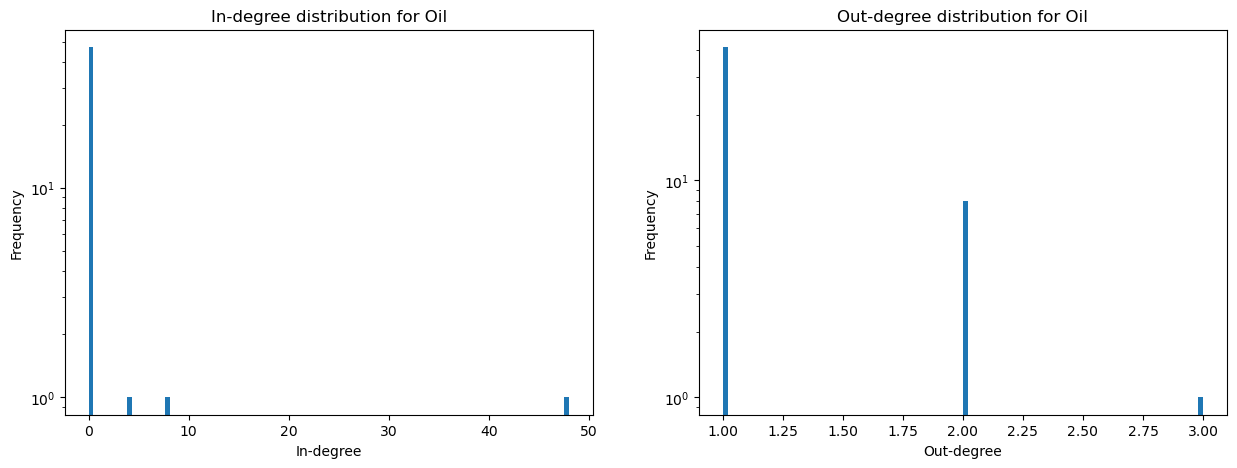

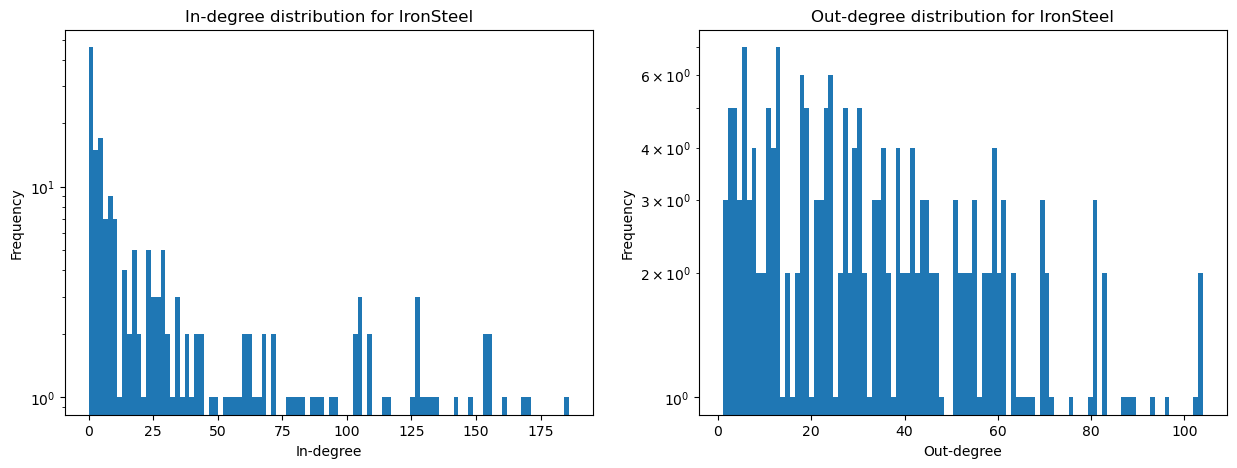

In [7]:
# Compute the in-degree and out-degree of the graphs
in_deg_oil = dict(G_oil.in_degree())
out_deg_oil = dict(G_oil.out_degree())
in_deg_steel = dict(G_steel.in_degree())
out_deg_steel = dict(G_steel.out_degree())

# Plot the in-degree and out-degree distributions
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(list(in_deg_oil.values()), bins=100, log=True)
ax[0].set_title('In-degree distribution for Oil')
ax[0].set_xlabel('In-degree')
ax[0].set_ylabel('Frequency')
ax[1].hist(list(out_deg_oil.values()), bins=100, log=True)
ax[1].set_title('Out-degree distribution for Oil')
ax[1].set_xlabel('Out-degree')
ax[1].set_ylabel('Frequency')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(list(in_deg_steel.values()), bins=100, log=True)
ax[0].set_title('In-degree distribution for IronSteel')
ax[0].set_xlabel('In-degree')
ax[0].set_ylabel('Frequency')
ax[1].hist(list(out_deg_steel.values()), bins=100, log=True)
ax[1].set_title('Out-degree distribution for IronSteel')
ax[1].set_xlabel('Out-degree')
ax[1].set_ylabel('Frequency')
plt.show()

In [8]:
# Compute the rank correlation between degree measures and trade volume
in_deg_oil = pd.Series(in_deg_oil)
out_deg_oil = pd.Series(out_deg_oil)
in_deg_steel = pd.Series(in_deg_steel)
out_deg_steel = pd.Series(out_deg_steel)

# Compute the rank correlation between in-degree and trade volume
print('Rank correlation between in-degree and trade volume for Oil:', in_deg_oil.corr(data.groupby('COUNTRY_CODE_IN')['VALUE'].sum(), method='spearman'))
print('Rank correlation between in-degree and trade volume for IronSteel:', in_deg_steel.corr(data.groupby('COUNTRY_CODE_IN')['VALUE'].sum(), method='spearman'))

# Compute the rank correlation between out-degree and trade volume
print('Rank correlation between out-degree and trade volume for Oil:', out_deg_oil.corr(data.groupby('COUNTRY_CODE_OUT')['VALUE'].sum(), method='spearman'))
print('Rank correlation between out-degree and trade volume for IronSteel:', out_deg_steel.corr(data.groupby('COUNTRY_CODE_OUT')['VALUE'].sum(), method='spearman'))

Rank correlation between in-degree and trade volume for Oil: 0.30992344328948496
Rank correlation between in-degree and trade volume for IronSteel: 0.9277967784619763
Rank correlation between out-degree and trade volume for Oil: 0.19557273916351023
Rank correlation between out-degree and trade volume for IronSteel: 0.8889437937635398


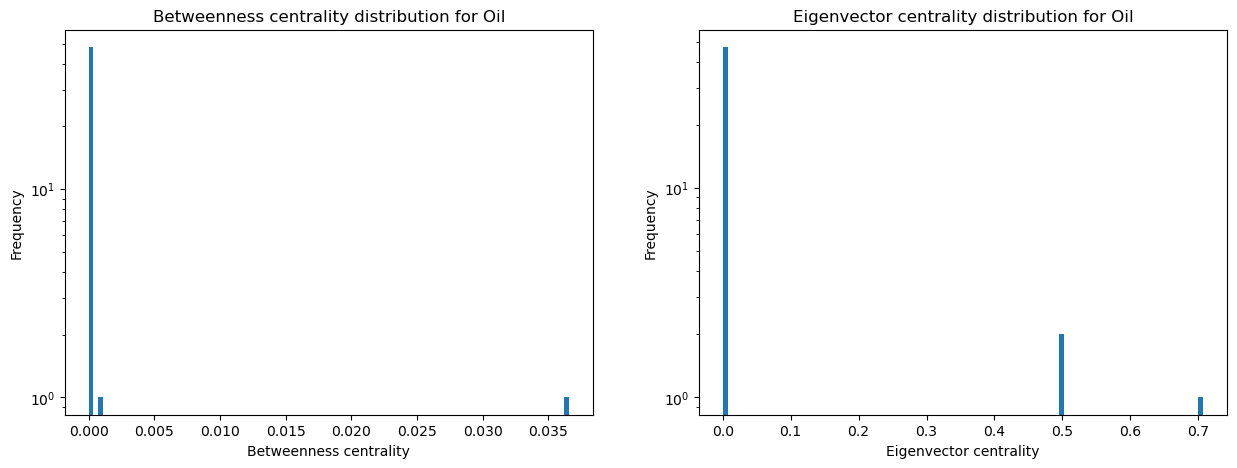

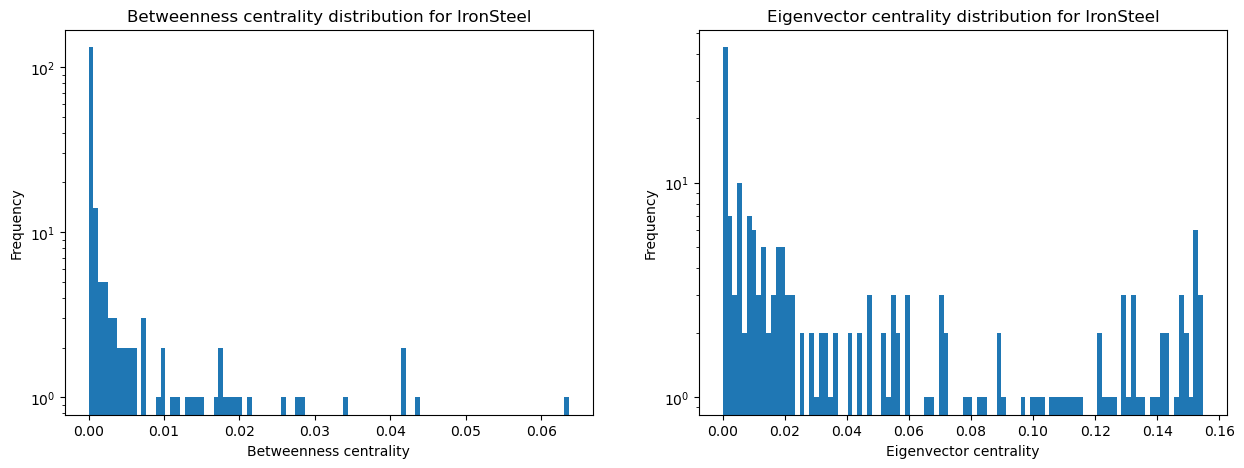

In [263]:
# Compute betweenness centrality and eigenvector centrality for the graphs
betweenness_oil = nx.betweenness_centrality(G_oil)
eigenvector_oil = nx.eigenvector_centrality(G_oil)
betweenness_steel = nx.betweenness_centrality(G_steel)
eigenvector_steel = nx.eigenvector_centrality(G_steel)

# Plot the betweenness centrality and eigenvector centrality distributions
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(list(betweenness_oil.values()), bins=100, log=True)
ax[0].set_title('Betweenness centrality distribution for Oil')
ax[0].set_xlabel('Betweenness centrality')
ax[0].set_ylabel('Frequency')
ax[1].hist(list(eigenvector_oil.values()), bins=100, log=True)
ax[1].set_title('Eigenvector centrality distribution for Oil')
ax[1].set_xlabel('Eigenvector centrality')
ax[1].set_ylabel('Frequency')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(list(betweenness_steel.values()), bins=100, log=True)
ax[0].set_title('Betweenness centrality distribution for IronSteel')
ax[0].set_xlabel('Betweenness centrality')
ax[0].set_ylabel('Frequency')
ax[1].hist(list(eigenvector_steel.values()), bins=100, log=True)
ax[1].set_title('Eigenvector centrality distribution for IronSteel')
ax[1].set_xlabel('Eigenvector centrality')
ax[1].set_ylabel('Frequency')
plt.show()

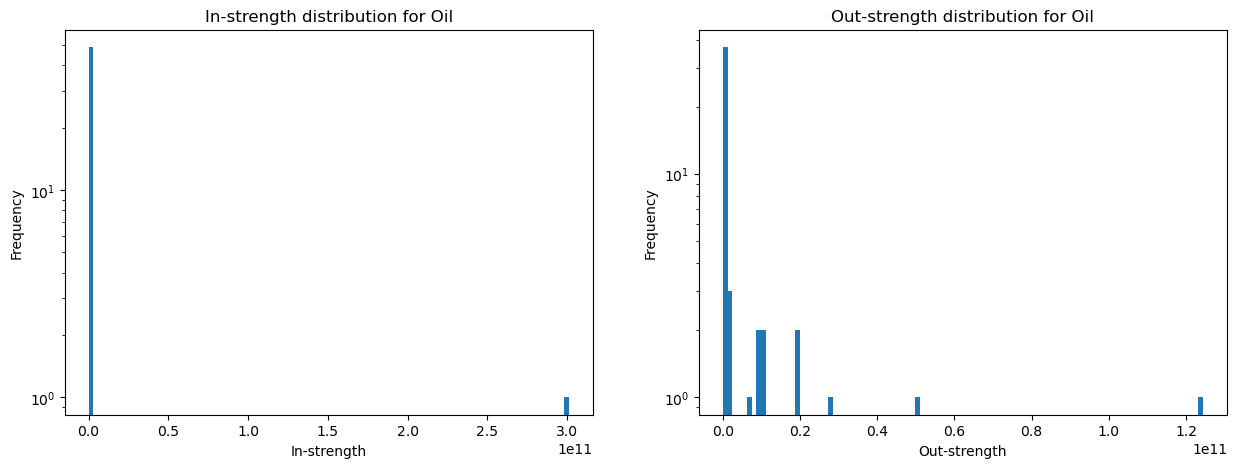

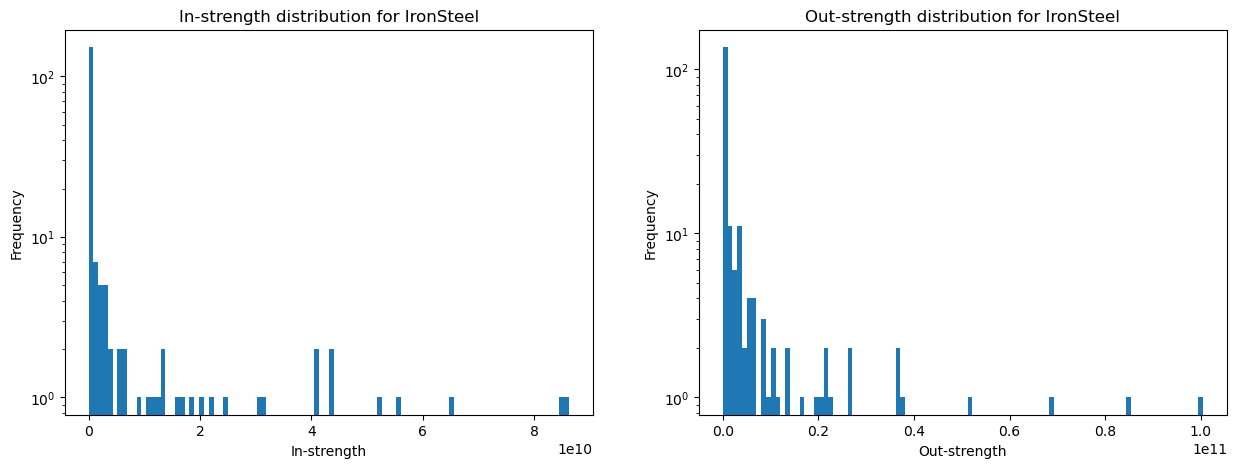

In [264]:
# Compute in-strength and out-strength for the graphs
in_strength_oil = dict(G_oil.in_degree(weight='weight'))
out_strength_oil = dict(G_oil.out_degree(weight='weight'))
in_strength_steel = dict(G_steel.in_degree(weight='weight'))
out_strength_steel = dict(G_steel.out_degree(weight='weight'))

# Plot the in-strength and out-strength distributions
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(list(in_strength_oil.values()), bins=100, log=True)
ax[0].set_title('In-strength distribution for Oil')
ax[0].set_xlabel('In-strength')
ax[0].set_ylabel('Frequency')
ax[1].hist(list(out_strength_oil.values()), bins=100, log=True)
ax[1].set_title('Out-strength distribution for Oil')
ax[1].set_xlabel('Out-strength')
ax[1].set_ylabel('Frequency')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(list(in_strength_steel.values()), bins=100, log=True)
ax[0].set_title('In-strength distribution for IronSteel')
ax[0].set_xlabel('In-strength')
ax[0].set_ylabel('Frequency')
ax[1].hist(list(out_strength_steel.values()), bins=100, log=True)
ax[1].set_title('Out-strength distribution for IronSteel')
ax[1].set_xlabel('Out-strength')
ax[1].set_ylabel('Frequency')
plt.show()

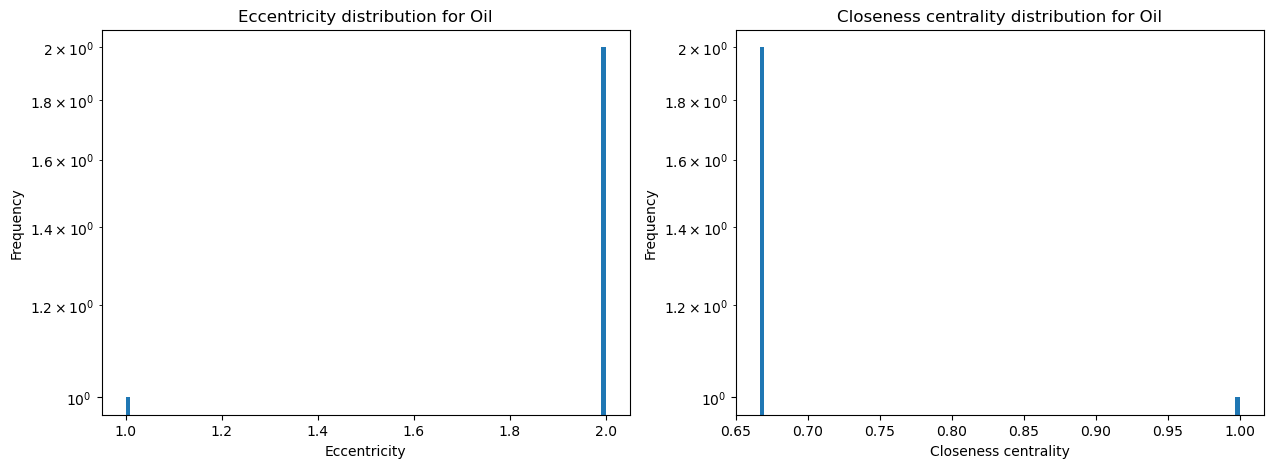

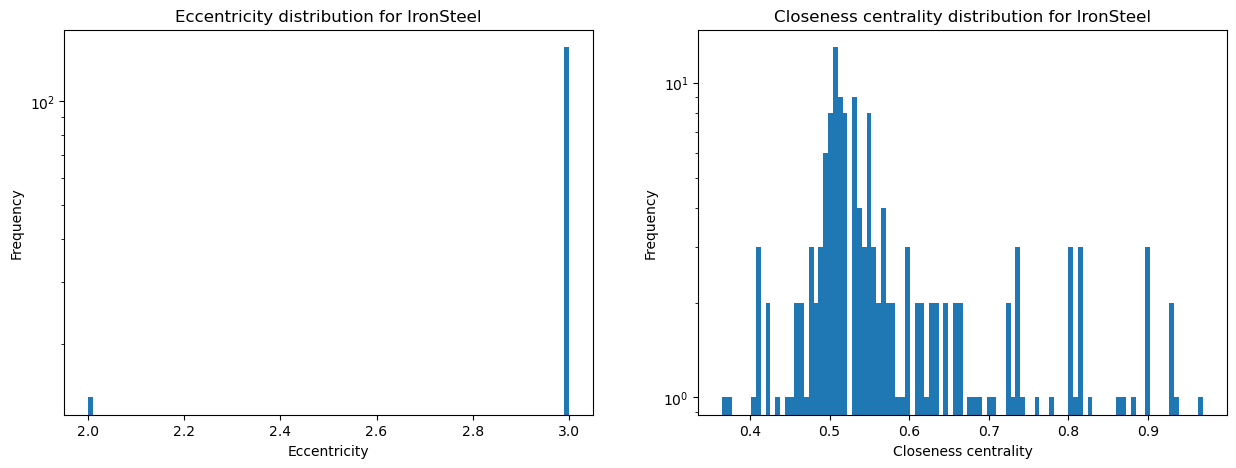

In [266]:
# Compute eccentricity and closeness centrality for the largest strongly connected component of the graphs
G_oil_scc = max(nx.strongly_connected_components(G_oil), key=len)
eccentricity_oil = nx.eccentricity(G_oil.subgraph(G_oil_scc))
closeness_oil = nx.closeness_centrality(G_oil.subgraph(G_oil_scc))
G_steel_scc = max(nx.strongly_connected_components(G_steel), key=len)
eccentricity_steel = nx.eccentricity(G_steel.subgraph(G_steel_scc))
closeness_steel = nx.closeness_centrality(G_steel.subgraph(G_steel_scc))

# Plot the eccentricity and closeness centrality distributions
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(list(eccentricity_oil.values()), bins=100, log=True)
ax[0].set_title('Eccentricity distribution for Oil')
ax[0].set_xlabel('Eccentricity')
ax[0].set_ylabel('Frequency')
ax[1].hist(list(closeness_oil.values()), bins=100, log=True)
ax[1].set_title('Closeness centrality distribution for Oil')
ax[1].set_xlabel('Closeness centrality')
ax[1].set_ylabel('Frequency')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(list(eccentricity_steel.values()), bins=100, log=True)
ax[0].set_title('Eccentricity distribution for IronSteel')
ax[0].set_xlabel('Eccentricity')
ax[0].set_ylabel('Frequency')
ax[1].hist(list(closeness_steel.values()), bins=100, log=True)
ax[1].set_title('Closeness centrality distribution for IronSteel')
ax[1].set_xlabel('Closeness centrality')
ax[1].set_ylabel('Frequency')
plt.show()

In [267]:
# Compute radius and diameter for the largest strongly connected component of the graphs
radius_oil = nx.radius(G_oil.subgraph(G_oil_scc))
diameter_oil = nx.diameter(G_oil.subgraph(G_oil_scc))
radius_steel = nx.radius(G_steel.subgraph(G_steel_scc))
diameter_steel = nx.diameter(G_steel.subgraph(G_steel_scc))

# Print the radius and diameter
print('Oil graph')
print('Radius:', radius_oil)
print('Diameter:', diameter_oil)
print()
print('IronSteel graph')
print('Radius:', radius_steel)
print('Diameter:', diameter_steel)

Oil graph
Radius: 1
Diameter: 2

IronSteel graph
Radius: 2
Diameter: 3


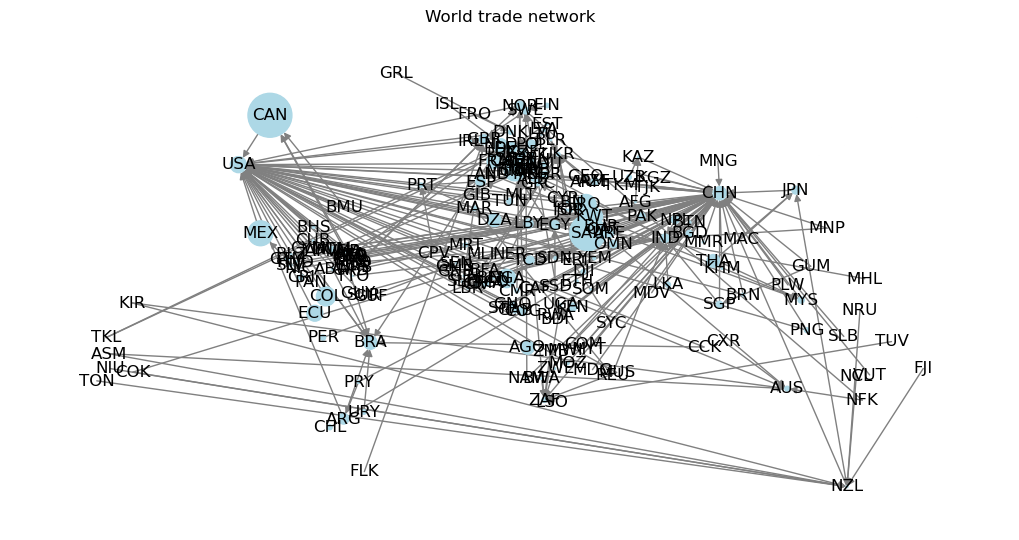

In [11]:
# Build a network from the data with only the two main export flows for each country
# (i.e. the two countries to which the country exports the most).
# Filter the network to keep only edges with a weight above a certain threshold.
G = nx.DiGraph()
for country in data['COUNTRY_CODE_OUT'].unique():
    country_data = data[data['COUNTRY_CODE_OUT'] == country]
    country_data = country_data.sort_values('VALUE', ascending=False)
    for i in range(2):
        if len(country_data) >= 2:
            G.add_edge(country, country_data['COUNTRY_CODE_IN'].iloc[i], weight=country_data['VALUE'].iloc[i])
# The weight of the edge between two countries is the value of the export flow.

# Draw the network and arrange it according to the world map.
# We use the latitude and longitude of the countries to do so.
# Make node size proportional to the total value of the export flows of the country.
pos = {}
for country in G.nodes():
    try:
        pos[country] = (float(data[data['COUNTRY_CODE_OUT'] == country]['LONGITUDE_OUT'].iloc[0]),
                        float(data[data['COUNTRY_CODE_OUT'] == country]['LATITUDE_OUT'].iloc[0]))
    except:
        pass
node_size = [G.out_degree(country, weight='weight') for country in G.nodes()]
node_size = np.array(node_size)
node_size = 1000 * (node_size - min(node_size)) / (max(node_size) - min(node_size))
node_size = node_size.astype(int)
plt.figure(figsize=(10, 5))

# Unclutter the plot by increasing space between nodes
# Put a true world map in the background
pos_higher = {}
y_off = 0.05  # offset on the y axis
for k, v in pos.items():
    pos_higher[k] = (v[0], v[1] + y_off)
nx.draw(G, pos_higher, with_labels=True, node_size=node_size, node_color='lightblue', edge_color='grey')

plt.title('World trade network')
plt.show()


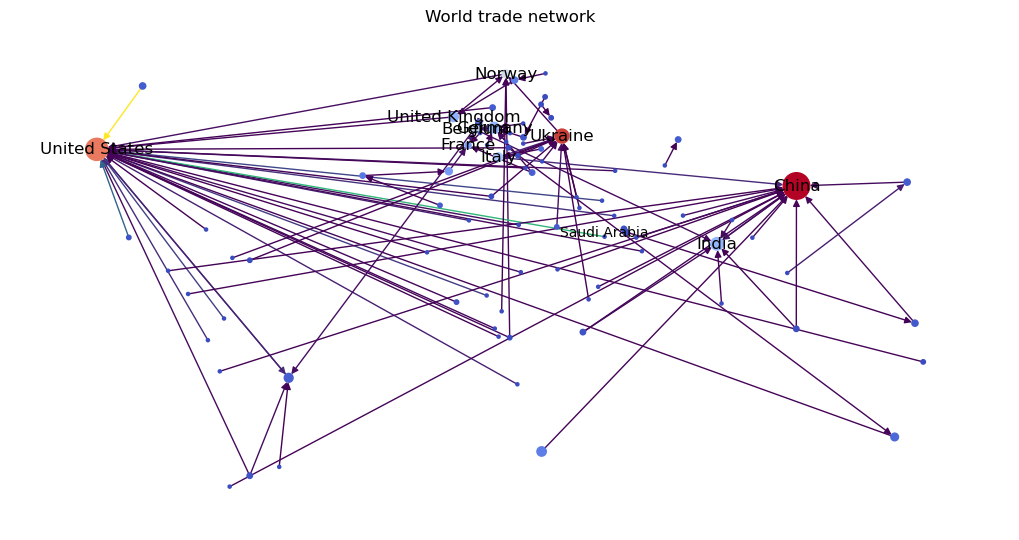

In [46]:
# Produce a filtered and colour-coded version of the network above to highlight the most important trade flows.
# It graph should be used to answer the question which countries are the most important in the world trade network.
# We use the betweenness centrality to colour the nodes.
# We use the weight of the edges to filter the network.
# We use the degree centrality to size the nodes.
# We use the latitude and longitude of the countries to arrange the nodes on the world map.
# We use the pycountry library to convert country codes to country names.
# We use the networkx library to compute the betweenness centrality and the eigenvector centrality.
# We use the matplotlib library to draw the network.

# Compute the betweenness centrality and the degree centrality
betweenness = nx.betweenness_centrality(G)
degree = nx.degree_centrality(G)

# Convert country codes to country names
country_names = {}
for country in G.nodes():
    try:
        country_names[country] = pycountry.countries.get(alpha_3=country).name
    except:
        pass
    
# Filter the network to keep only edges with a weight above a certain threshold
G_filtered = nx.DiGraph()
for u, v, d in G.edges(data=True):
    if d['weight'] > 1e7:
        G_filtered.add_edge(u, v, weight=d['weight'])
    
# Draw the network and arrange it according to the world map
# Make node size proportional to the eigenvector centrality
# Make node color proportional to the betweenness centrality
# Make edge color proportional to the weight of the edge
pos = {}
for country in G_filtered.nodes():
    try:
        pos[country] = (float(data[data['COUNTRY_CODE_OUT'] == country]['LONGITUDE_OUT'].iloc[0]),
                        float(data[data['COUNTRY_CODE_OUT'] == country]['LATITUDE_OUT'].iloc[0]))
    except:
        pass
node_size = [1000 * degree[country] for country in G_filtered.nodes()]
node_color = [betweenness[country] for country in G_filtered.nodes()]
edge_color = [G_filtered[u][v]['weight'] for u, v in G_filtered.edges()]
edge_color = np.array(edge_color)
edge_color = 1000 * (edge_color - min(edge_color)) / (max(edge_color) - min(edge_color))
edge_color = edge_color.astype(int)
plt.figure(figsize=(10, 5))

# Unclutter the plot by increasing space between nodes
# Put a true world map in the background
pos_higher = {}
y_off = 0.05  # offset on the y axis
for k, v in pos.items():
    pos_higher[k] = (v[0], v[1] + y_off)
    
# Only plot the labels of the 10 most important nodes
sortdict = dict(sorted(betweenness.items(), key=lambda item: item[1], reverse=True))
nx.draw(G_filtered, pos_higher, with_labels=True, labels={k: country_names[k] for k in list(sortdict.keys())[:10]}, node_size=node_size, node_color=node_color, edge_color=edge_color, cmap='coolwarm')
#nx.draw(G_filtered, pos_higher, with_labels=True, node_size=node_size, node_color=node_color, edge_color=edge_color, cmap='coolwarm')

# Label the Saudi Arabia node
plt.text(pos_higher['SAU'][0], pos_higher['SAU'][1] + y_off, 'Saudi Arabia', horizontalalignment='center')

plt.title('World trade network')
plt.show()

In [42]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

/var/folders/z6/68v8p58j3kq5zj0jfk13dz300000gn/T/ipykernel_10854/1771207407.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<Axes: >

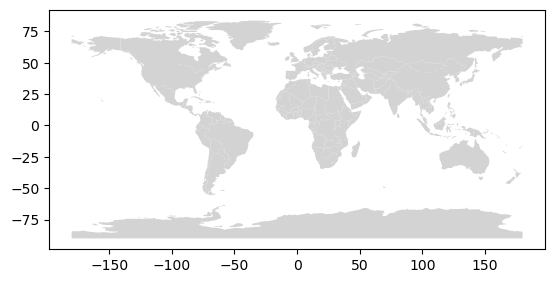

In [43]:
countries.plot(color="lightgrey")

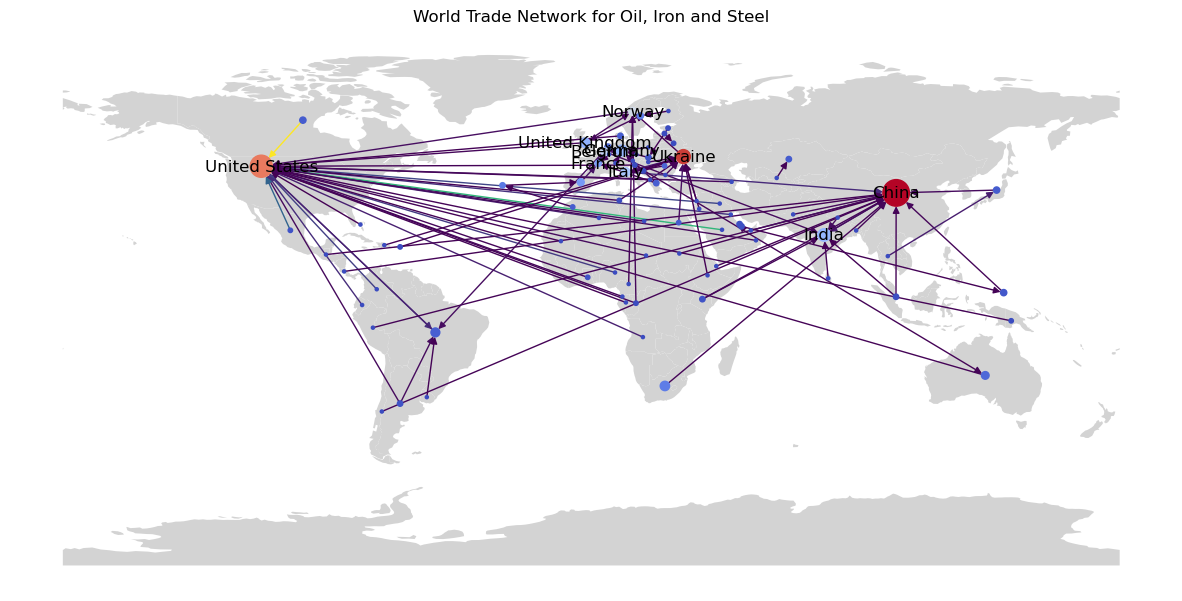

In [50]:
# Plot the graph on top of the world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
countries.plot(ax=ax, color="lightgrey")
sortdict = dict(sorted(betweenness.items(), key=lambda item: item[1], reverse=True))
nx.draw(G_filtered, pos_higher, with_labels=True, labels={k: country_names[k] for k in list(sortdict.keys())[:10]}, node_size=node_size, node_color=node_color, edge_color=edge_color, cmap='coolwarm')
plt.title('World Trade Network for Oil, Iron and Steel')

plt.show()